In [2]:
import random
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
%matplotlib inline

import dataloader
import util
import autoencoderdual

#load data
dataset = dataloader.DataLoader(verbose=True)
x_train, x_test, y_train, y_test, y_reg_train, y_reg_test = dataset.load_data()

#load lsi architecture
LSI = autoencoderdual.Autoencoder(x_train, y_reg_train)
LSI.train_autoencoder_dual(epoch=200, load=True)

Loaded training data x (60000, 28, 28, 1) and y (60000, 128) and y_labels (60000,)
Loaded testing data x (10000, 28, 28, 1) and y (10000, 128) and y_labels (10000,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 100)          12900       input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 100)          0           dense_19[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 80) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
enc (Conv2D)                 (None, 28, 28, 4)         40        
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 28, 28, 4)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 8)         520       
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 8)         32        
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 14, 14, 8)         0         
__________

In [3]:
#get variables
D_test_hat = LSI.d2d.predict(y_reg_test)
M_test_hat = LSI.m2m.predict(x_test)
M_test_hat_reg = LSI.d2m.predict(y_reg_test)

#get data latent variables
zd_test = LSI.d2zd.predict(y_reg_test)

#get model latent variables
zm_test = LSI.m2zm.predict(x_test)

#get data to model latent variables (inversion)
zm_test_reg = LSI.zd2zm.predict(zd_test)

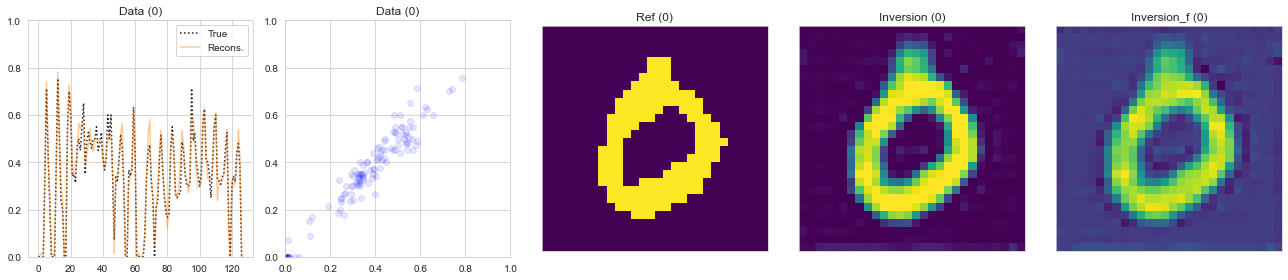

In [5]:
#reference case (in original dimension)

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

case = 3   
f = plt.figure(figsize=(18,4))
#data and data reconstruction
ax = f.add_subplot(1, 5, 1)
plt.plot(y_reg_test[case, :], ls=':', c='k', label='True', alpha=0.9)
plt.plot(D_test_hat[case, :], c=cs[y_test[case]], label='Recons.', alpha=0.4)
plt.ylim([0, 1])
plt.title('Data ('+str(y_test[case])+')')
plt.legend()

#data and data reconstruction (scatter)
ax = f.add_subplot(1, 5, 2)
plt.scatter(D_test_hat[case, :].flatten(), y_reg_test[case, :].flatten(), color='blue', alpha=0.1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Data ('+str(y_test[case])+')')
    
#model (i.e. reference case)
ax = f.add_subplot(1, 5, 3)
plt.imshow(x_test[case, :, :, 0], cmap='viridis', vmin=0, vmax=1)
plt.title('Ref ('+str(y_test[case])+')')
plt.grid(False), plt.xticks([]), plt.yticks([])

#predicted model (i.e. inversion)
ax = f.add_subplot(1, 5, 4)
plt.imshow(M_test_hat_reg[1][case, :, :, 0], cmap='viridis', vmin=0, vmax=1)
plt.title('Inversion ('+str(y_test[case])+')')
plt.grid(False), plt.xticks([]), plt.yticks([])

#predicted model (i.e. inversion) colormap limit removed to show diffr
ax = f.add_subplot(1, 5, 5)
plt.imshow(M_test_hat_reg[1][case, :, :, 0], cmap='viridis')
plt.title('Inversion_f ('+str(y_test[case])+')')
plt.grid(False), plt.xticks([]), plt.yticks([])

plt.tight_layout()
f.savefig('readme/test_sigs_ref_recons_demo.png', dpi=300)

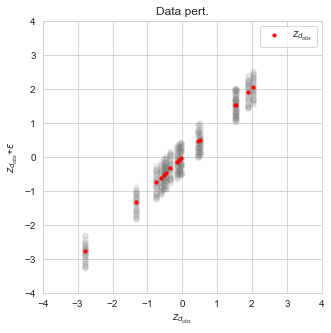

In [6]:
#workflow demo, with a reference case (index #3 in test dataset)
zd_obs = zd_test[case, :]

#sample the latent space around the observed data
num_samples = 64
zd_obs_pert = np.zeros([num_samples, zd_obs.shape[0]])
zd_obs_pert[:,:] = zd_obs

#perturb ~20%
pert = np.random.uniform(0, 1, [num_samples, zd_obs.shape[0]]) - 0.5
zd_obs_pert = zd_obs_pert + pert

#plot scatter
f = plt.figure(figsize=(5, 5))
plt.scatter(zd_obs.flatten(), zd_obs.flatten(), s=10, color='red', alpha=1, label="$z_{d_{obs}}$", zorder=20)
for i in range(num_samples):
    plt.scatter(zd_obs.flatten(), zd_obs_pert[i,:].flatten(), s=30, color='gray', alpha=0.05)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.xlabel("$z_{d_{obs}}$")
plt.ylabel("$z_{d_{obs}}$"+"+$\epsilon$")
plt.legend()
plt.title('Data pert.')
f.savefig('readme/test_zds_scatter_demo.png')

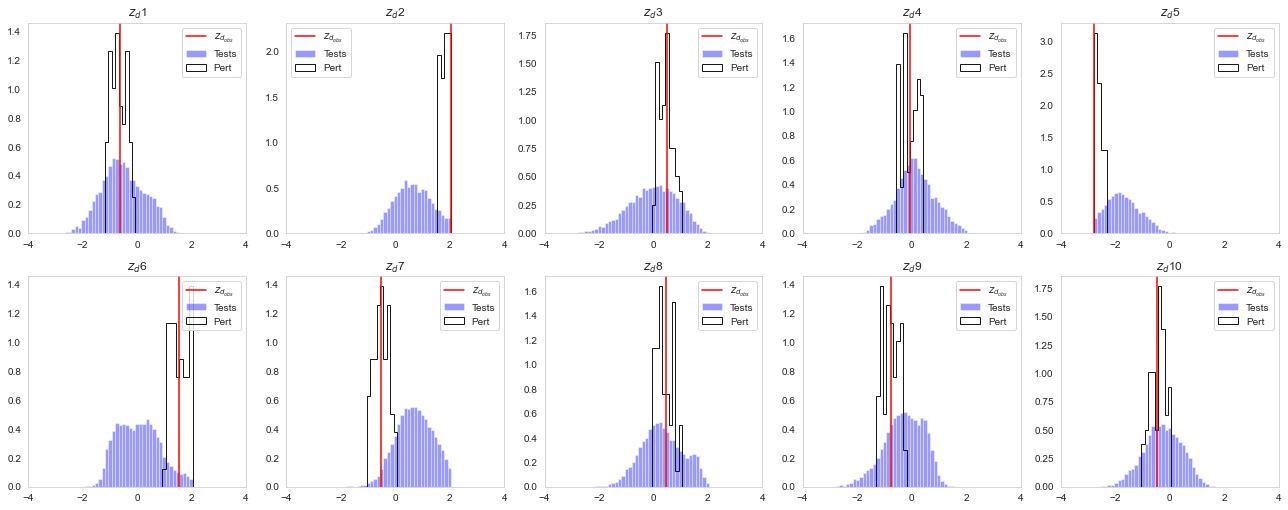

In [9]:
#latent spaces for the data

zd_obs = zd_test[case, :]

binmax = np.max(zd_obs)
binmin = np.min(zd_obs)
bb2 = np.linspace(binmin, binmax, 40)

f = plt.figure(figsize=(18, 14))
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.hist(zd_test[:, i].flatten(), color='blue', alpha=0.4, bins=bb2, density=True, label="Tests")
    plt.hist(zd_obs_pert[:, i].flatten(), color='blue', alpha=0.9, edgecolor='black', histtype='step', bins=bb2, density=True, label="Pert")
    plt.axvline(x=zd_obs[i], c='r', label="$z_{d_{obs}}$")
    plt.grid(False)
    plt.xlim(-4, 4), 
    plt.title('$z_{d}$'+str(i+1))
    plt.legend()
f.tight_layout()
f.savefig('readme/test_zds_demo.png', dpi=300)

In [10]:
#get the corresponding model latent variables
zm_ref_pert = LSI.zd2zm.predict(zd_obs_pert)

#get the inversion solutions for the perturbed set
M_test_hat_reg_pert = LSI.zm2m.predict(zm_ref_pert)

#take cut off (0 and 1, cutoff at 0.5 for discrettization)
M_test_hat_reg_pert = np.where(M_test_hat_reg_pert<0.5, 0, 1)

#run forward simulation on the perturbed images
G = np.load('G.npy')
y_dim = G.shape[-1]
D_test_hat_reg_pert = np.zeros([M_test_hat_reg_pert.shape[0], y_dim])
for i in range(M_test_hat_reg_pert.shape[0]):
    D_test_hat_reg_pert[i:i+1, :] = np.reshape((M_test_hat_reg_pert[i:i+1, :, :, 0]), [1, M_test_hat_reg_pert.shape[1]*M_test_hat_reg_pert.shape[2]])@G
    
#normalize using the same normalization factor for the training dataset
D_test_hat_reg_pert = D_test_hat_reg_pert/(dataset.maxs)

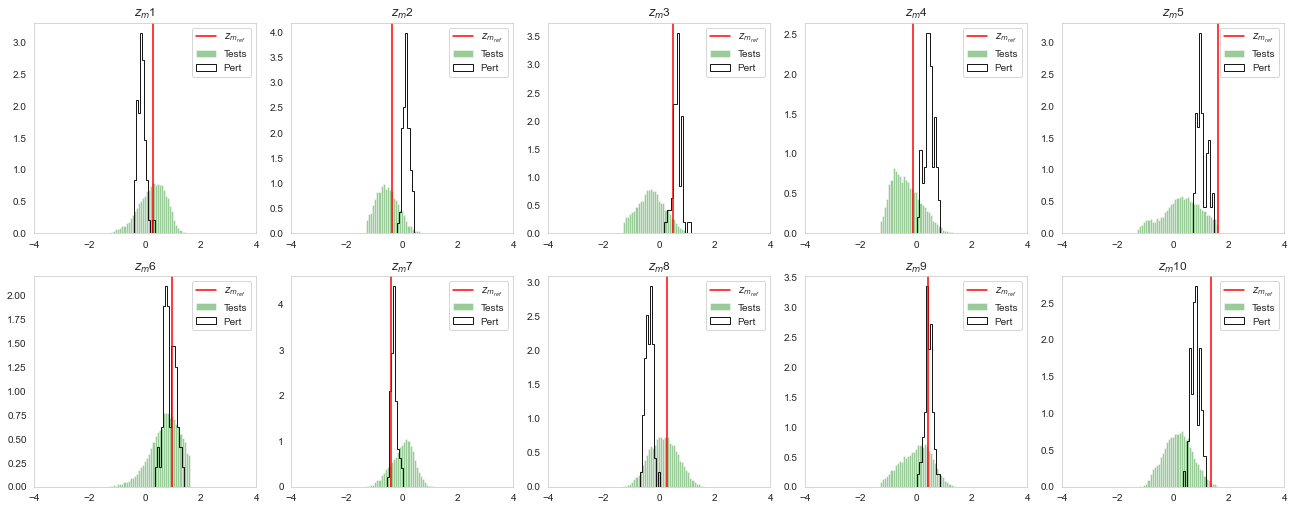

In [11]:
#latent spaces for the model

zm_ref = zm_test[case, :]

binmax = np.max(zm_ref)
binmin = np.min(zm_ref)
bb2 = np.linspace(binmin, binmax, 40)

f = plt.figure(figsize=(18, 14))
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.hist(zm_test[:, i].flatten(), color='green', alpha=0.4, bins=bb2, density=True, label="Tests")
    plt.hist(zm_ref_pert[:, i].flatten(), color='green', alpha=0.9, edgecolor='black', histtype='step', bins=bb2, density=True, label="Pert")
    plt.axvline(x=zm_ref[i], c='r', label="$z_{m_{ref}}$")
    plt.grid(False)
    plt.xlim(-4, 4), 
    plt.title('$z_{m}$'+str(i+1))
    plt.legend()
f.tight_layout()
f.savefig('readme/test_zms_demo.png', dpi=300)

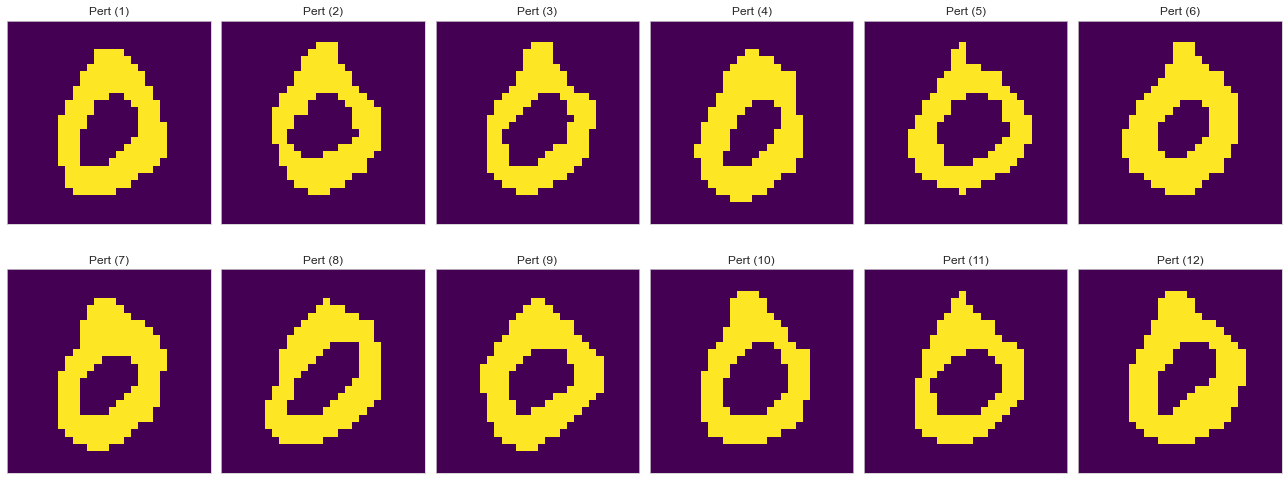

In [12]:
#view perturbed images (rescaled)

f = plt.figure(figsize=(18, 14))
for i in range(12):
    plt.subplot(4, 6, i+1)
    plt.imshow(M_test_hat_reg_pert[i, :, :, 0], cmap='viridis')
    plt.title('Pert ('+str(i+1)+')')
    plt.grid(False), plt.xticks([]), plt.yticks([])
plt.tight_layout()
f.savefig('readme/test_m_pert_demo.png', dpi=300)

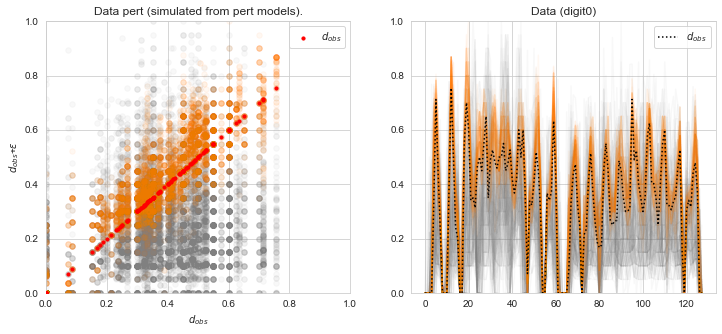

In [13]:
#view perturbed data

f = plt.figure(figsize=(12, 5))
ax = f.add_subplot(1, 2, 1)
plt.scatter(y_reg_test[case,:].flatten(), y_reg_test[case,:].flatten(), s=10, color='red', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.scatter(y_reg_test[case,:].flatten(), y_reg_test[i,:].flatten(), s=30, color='gray', alpha=0.05)
for i in range(num_samples):
    plt.scatter(y_reg_test[case,:].flatten(), D_test_hat_reg_pert[i,:].flatten(), s=30, color=cs[y_test[case]], alpha=0.05)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("$d_{obs}$")
plt.ylabel("$d_{obs}$"+"+$\epsilon$")
plt.legend()
plt.title('Data pert (simulated from pert models).')

ax = f.add_subplot(1, 2, 2)
timesteps = np.linspace(0, 127, 128)
plt.plot(timesteps, y_reg_test[case,:], ls=':', c='k', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.plot(timesteps, y_reg_test[i,:], color='gray', alpha=0.05)
for i in range(num_samples):
    plt.plot(timesteps, D_test_hat_reg_pert[i,:], color=cs[y_test[case]], alpha=0.05)
plt.ylim([0, 1])
plt.title('Data (digit'+str(y_test[case])+')')
plt.legend()
f.savefig('readme/test_d_pert_demo.png', dpi=300)